<a href="https://colab.research.google.com/github/Sneha-P-Karunakaran/Deep-Learning-Projects/blob/main/Emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

In [ ]:
#importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding,LSTM,Dense,GRU,Bidirectional,Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler

In [ ]:
# Downloading NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Loading dataset
df = pd.read_csv('/content/Emotion_classify_Data.csv')

In [ ]:
print(df.head())

                                             Comment Emotion
0  i seriously hate one subject to death but now ...    fear
1                 im so full of life i feel appalled   anger
2  i sit here to write i start to dig out my feel...    fear
3  ive been really angry with r and i feel like a...     joy
4  i feel suspicious if there is no one outside l...    fear


In [ ]:
print(df.describe())

                                                 Comment Emotion
count                                               5937    5937
unique                                              5934       3
top     i feel like a tortured artist when i talk to her   anger
freq                                                   2    2000


In [ ]:
# Tokenization and Preprocessing
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [ ]:
def preprocess_text(text):
    words = word_tokenize(text)
    filtered_words = [stemmer.stem(word.lower()) for word in words if word.lower() not in stop_words and word.isalnum()]
    return ' '.join(filtered_words)

In [ ]:
# Apply preprocessing
df['clean_text'] = df['Comment'].apply(preprocess_text)
df['clean_text']

,clean_text
0,serious hate one subject death feel reluct drop
1,im full life feel appal
2,sit write start dig feel think afraid accept p...
3,ive realli angri r feel like idiot trust first...
4,feel suspici one outsid like raptur happen someth
...,...
5932,begun feel distress
5933,left feel annoy angri think center stupid joke
5934,ever get marri everyth readi offer got togeth ...
5935,feel reluct appli want abl find compani know l...


In [ ]:
# Checking sufficient unique labels
if df['Emotion'].nunique() < 2:
    raise ValueError("Insufficient unique labels for classification.")

In [ ]:
# Split data into features and labels
X = df['clean_text']
X

,clean_text
0,serious hate one subject death feel reluct drop
1,im full life feel appal
2,sit write start dig feel think afraid accept p...
3,ive realli angri r feel like idiot trust first...
4,feel suspici one outsid like raptur happen someth
...,...
5932,begun feel distress
5933,left feel annoy angri think center stupid joke
5934,ever get marri everyth readi offer got togeth ...
5935,feel reluct appli want abl find compani know l...


In [ ]:
y = df['Emotion']
y

,Emotion
0,fear
1,anger
2,fear
3,joy
4,fear
...,...
5932,fear
5933,anger
5934,joy
5935,fear


In [ ]:
# Encoding labels for LSTM
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Tokenize text and convert to sequences for LSTM
max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Pad sequences for equal length input to neural network
max_len = 150
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [ ]:
# Building the model
embedding_dim = 100
num_classes = len(label_encoder.classes_)

In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(GRU(64)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile model with learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

In [ ]:
learning_rate_scheduler = LearningRateScheduler(scheduler)
optimizer = Adam(learning_rate=1e-3)

In [ ]:
#Compiling the model
model.complie(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=['accuracy'])

In [ ]:
# Train the model with early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')

In [ ]:
history = model.fit(X_train_pad, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stopping, learning_rate_scheduler, model_checkpoint])

Epoch 1/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 119s 821ms/step - accuracy: 0.4267 - loss: 1.0265 - val_accuracy: 0.8632 - val_loss: 0.4127 - learning_rate: 0.0010
Epoch 2/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 135s 772ms/step - accuracy: 0.9405 - loss: 0.1857 - val_accuracy: 0.9116 - val_loss: 0.2686 - learning_rate: 0.0010
Epoch 3/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 142s 770ms/step - accuracy: 0.9815 - loss: 0.0617 - val_accuracy: 0.9116 - val_loss: 0.3205 - learning_rate: 0.0010
Epoch 4/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9890 - loss: 0.0328 - val_accuracy: 0.9200 - val_loss: 0.3582 - learning_rate: 0.0010
Epoch 5/30
134/134 ━━━━━━━━━━━━━━━━━━━━ 110s 811ms/step - accuracy: 0.9941 - loss: 0.0244 - val_accuracy: 0.9074 - val_loss: 0.4586 - learning_rate: 0.0010


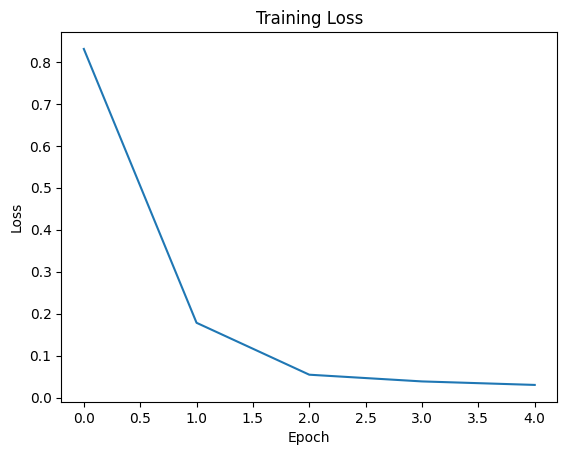

In [ ]:
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print("\nUpdated LSTM Classifier:")
print("Test Accuracy:", accuracy)

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.9093 - loss: 0.3739

Updated LSTM Classifier:
Test Accuracy: 0.9124578833580017


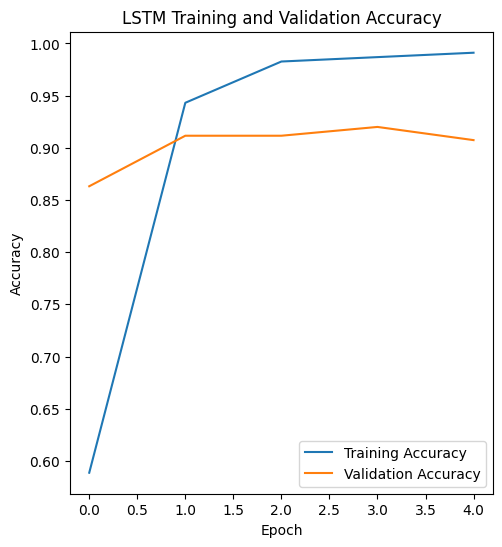

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

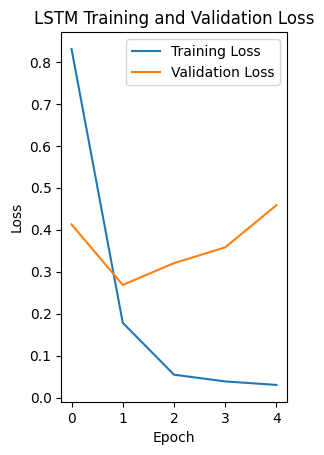

In [ ]:
# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predictions
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step


In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

       anger       0.90      0.95      0.92       392
        fear       0.96      0.88      0.92       416
         joy       0.89      0.91      0.90       380

    accuracy                           0.91      1188
   macro avg       0.91      0.91      0.91      1188
weighted avg       0.91      0.91      0.91      1188



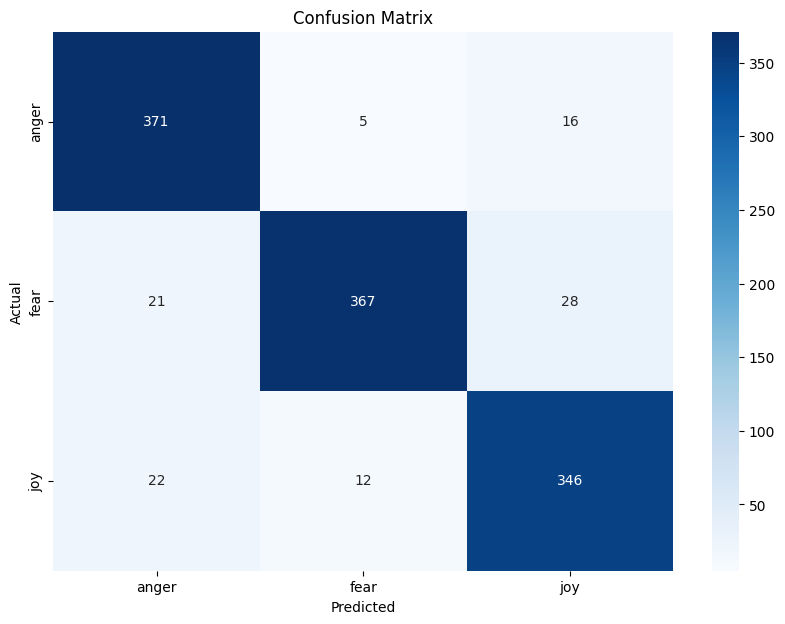

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()